# Probablistic Interpretation

### 0. Imports & data generation

X shape: (100, 1)
y shape: (100,)


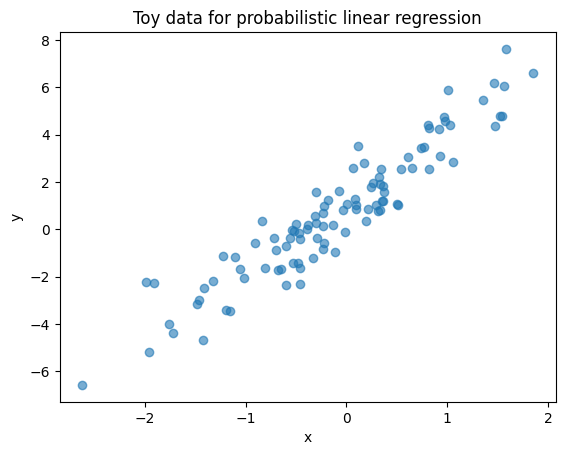

In [20]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# True parameters
true_theta0 = 1.0
true_theta1 = 3.0
true_sigma2 = 1.0 ** 2   # σ² = 1.0  # variance of Gaussian noise

# Generate toy data
n = 100
X = np.random.randn(n, 1)                       # shape (n, 1)
noise = np.sqrt(true_sigma2) * np.random.randn(n)
y = true_theta0 + true_theta1 * X.flatten() + noise

def add_bias(X):
    n = X.shape[0]
    return np.c_[np.ones((n, 1)), X]           # (n, d+1)

Xb = add_bias(X)

print("X shape:", X.shape)
print("y shape:", y.shape)

# Scatter to see the data
plt.scatter(X, y, alpha=0.6)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Toy data for probabilistic linear regression")
plt.show()

### 1. Deterministic view: normal equation θ̂


True θ      : [1.0, 3.0]
Normal eq θ : [1.00742783 2.85674284]


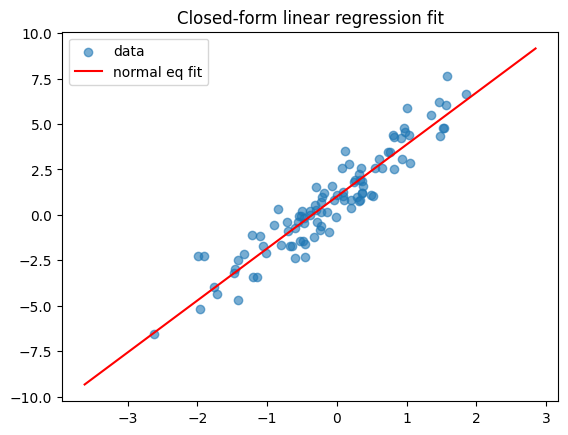

In [21]:
def normal_equation(X, y):
    Xb = add_bias(X)
    XtX = Xb.T @ Xb
    Xty = Xb.T @ y
    theta_hat = np.linalg.inv(XtX) @ Xty
    return theta_hat

theta_ne = normal_equation(X, y)
print("True θ      :", [true_theta0, true_theta1])
print("Normal eq θ :", theta_ne)

# Helper for predictions
def predict(X, theta):
    return add_bias(X) @ theta

# Plot line from closed-form θ̂
xs = np.linspace(X.min() - 1, X.max() + 1, 200).reshape(-1, 1)
ys_ne = predict(xs, theta_ne)

plt.scatter(X, y, alpha=0.6, label="data")
plt.plot(xs, ys_ne, color="red", label="normal eq fit")
plt.legend()
plt.title("Closed-form linear regression fit")
plt.show()


### 2. Squared error cost J(θ)


In [22]:
def cost(theta, X, y):
    Xb = add_bias(X)
    diff = Xb @ theta - y
    return 0.5 * np.mean(diff ** 2)           # (1/2n) Σ (ŷ - y)^2

def grad(theta, X, y):
    Xb = add_bias(X)
    diff = Xb @ theta - y
    return (Xb.T @ diff) / len(y)             # (1/n) Xᵀ (Xθ - y)

cost_ne = cost(theta_ne, X, y)
print("Cost at normal eq θ:", cost_ne)

Cost at normal eq θ: 0.4418162411456443


### 3. Probabilistic model & log-likelihood ℓ(θ)


In [23]:
def log_likelihood(theta, X, y, sigma2):
    """
    ℓ(θ) = Σ log N(y^(i); θᵀ x^(i), σ^2)
         = -n/2 log(2πσ^2) - (1 / (2σ^2)) Σ (y^(i) - θᵀ x^(i))^2
    """
    Xb = add_bias(X)
    diff = y - Xb @ theta
    n = len(y)
    const_term = -0.5 * n * np.log(2 * np.pi * sigma2)
    quad_term = -0.5 / sigma2 * np.sum(diff ** 2)
    return const_term + quad_term

# Compare log-likelihood for different θ
theta_random = np.array([0.0, 0.0])
theta_true = np.array([true_theta0, true_theta1])

ll_random = log_likelihood(theta_random, X, y, true_sigma2)
ll_ne = log_likelihood(theta_ne, X, y, true_sigma2)
ll_true = log_likelihood(theta_true, X, y, true_sigma2)

print("Log-likelihood at random θ :", ll_random)
print("Log-likelihood at true θ   :", ll_true)
print("Log-likelihood at normal θ :", ll_ne)

Log-likelihood at random θ : -494.515875003596
Log-likelihood at true θ   : -136.93821065514777
Log-likelihood at normal θ : -136.0754774350317


### 4. Visualizing likelihood


 Fix θ1 and vary θ0, then fix θ0 and vary θ1


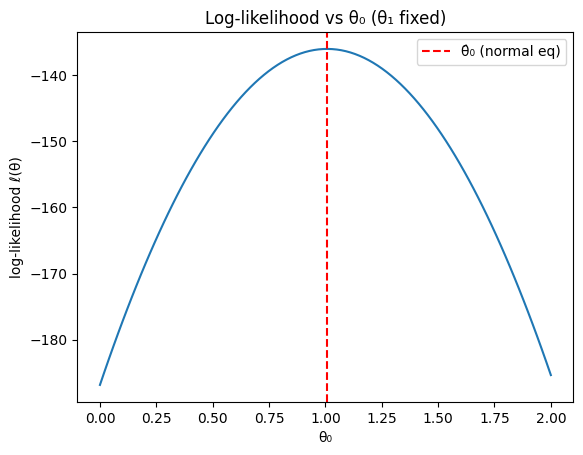

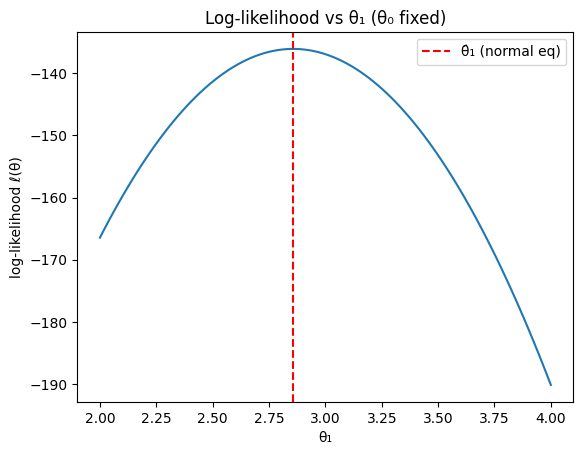

In [24]:
theta0_vals = np.linspace(true_theta0 - 1.0, true_theta0 + 1.0, 100)
ll_theta0 = [
    log_likelihood(np.array([t0, theta_ne[1]]), X, y, true_sigma2)
    for t0 in theta0_vals
]

theta1_vals = np.linspace(true_theta1 - 1.0, true_theta1 + 1.0, 100)
ll_theta1 = [
    log_likelihood(np.array([theta_ne[0], t1]), X, y, true_sigma2)
    for t1 in theta1_vals
]

plt.plot(theta0_vals, ll_theta0)
plt.axvline(theta_ne[0], color="red", linestyle="--", label="θ̂₀ (normal eq)")
plt.xlabel("θ₀")
plt.ylabel("log-likelihood ℓ(θ)")
plt.title("Log-likelihood vs θ₀ (θ₁ fixed)")
plt.legend()
plt.show()

plt.plot(theta1_vals, ll_theta1)
plt.axvline(theta_ne[1], color="red", linestyle="--", label="θ̂₁ (normal eq)")
plt.xlabel("θ₁")
plt.ylabel("log-likelihood ℓ(θ)")
plt.title("Log-likelihood vs θ₁ (θ₀ fixed)")
plt.legend()
plt.show()

### 5. Showing MLE ↔ minimizing squared error


 Grid search over θ0, θ1 to see where both J(θ) and -ℓ(θ) are minimized.


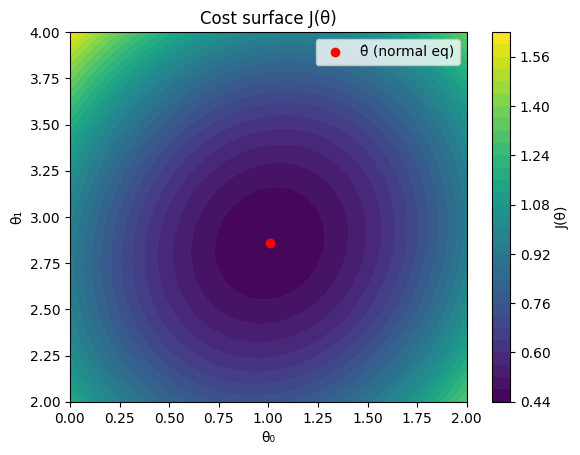

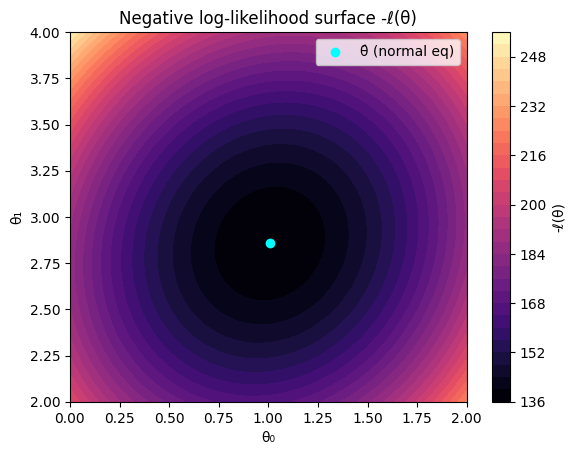

In [25]:
theta0_grid = np.linspace(true_theta0 - 1.0, true_theta0 + 1.0, 60)
theta1_grid = np.linspace(true_theta1 - 1.0, true_theta1 + 1.0, 60)

J_grid = np.zeros((len(theta0_grid), len(theta1_grid)))
LL_grid = np.zeros_like(J_grid)

for i, t0 in enumerate(theta0_grid):
    for j, t1 in enumerate(theta1_grid):
        theta_ij = np.array([t0, t1])
        J_grid[i, j] = cost(theta_ij, X, y)
        LL_grid[i, j] = -log_likelihood(theta_ij, X, y, true_sigma2)  # negative ll

# Heatmap-like contour for cost
T0, T1 = np.meshgrid(theta0_grid, theta1_grid, indexing="ij")

plt.contourf(T0, T1, J_grid, levels=30, cmap="viridis")
plt.colorbar(label="J(θ)")
plt.scatter([theta_ne[0]], [theta_ne[1]], color="red", label="θ̂ (normal eq)")
plt.xlabel("θ₀")
plt.ylabel("θ₁")
plt.title("Cost surface J(θ)")
plt.legend()
plt.show()

plt.contourf(T0, T1, LL_grid, levels=30, cmap="magma")
plt.colorbar(label="-ℓ(θ)")
plt.scatter([theta_ne[0]], [theta_ne[1]], color="cyan", label="θ̂ (normal eq)")
plt.xlabel("θ₀")
plt.ylabel("θ₁")
plt.title("Negative log-likelihood surface -ℓ(θ)")
plt.legend()
plt.show()

The θ that minimizes J(θ) is the same θ that maximizes ℓ(θ), which matches the derivation: arg max_θ ℓ(θ) = arg min_θ J(θ).

### Estimate Noise Variance (σ²) via MLE

In [29]:
def mle_sigma2(theta, X, y):
    residuals = y - add_bias(X) @ theta
    return np.mean(residuals ** 2)

sigma2_hat = mle_sigma2(theta_ne, X, y)

print("True σ²      :", true_sigma2)
print("Estimated σ² :", sigma2_hat)



True σ²      : 1.0
Estimated σ² : 0.8836324822912885


Instead of always using true_sigma2, Using Estimated σ² in Log-Likelihood (More Realistic)

In [30]:
ll_ne = log_likelihood(theta_ne, X, y, sigma2_hat)
ll_true = log_likelihood(theta_true, X, y, sigma2_hat)


In [32]:
def parameter_confidence_intervals(theta, X, sigma2, alpha=0.05):
    Xb = add_bias(X)
    XtX_inv = np.linalg.inv(Xb.T @ Xb)
    std_errors = np.sqrt(np.diag(sigma2 * XtX_inv))

    z = 1.96  # 95% CI
    lower = theta - z * std_errors
    upper = theta + z * std_errors

    return lower, upper, std_errors

ci_lower, ci_upper, std_err = parameter_confidence_intervals(
    theta_ne, X, sigma2_hat
)

print("θ̂        :", theta_ne)
print("Std error :", std_err)
print("95% CI lower:", ci_lower)
print("95% CI upper:", ci_upper)



θ̂        : [1.00742783 2.85674284]
Std error : [0.09462045 0.10402838]
95% CI lower: [0.82197175 2.65284721]
95% CI upper: [1.19288391 3.06063847]


### Predictive Uncertainty Bands

In [33]:
def predictive_interval(x, theta, X, sigma2):
    Xb = add_bias(X)
    XtX_inv = np.linalg.inv(Xb.T @ Xb)

    x_b = np.array([1, x])
    mean = x_b @ theta
    var = sigma2 * (1 + x_b @ XtX_inv @ x_b.T)

    return mean, np.sqrt(var)



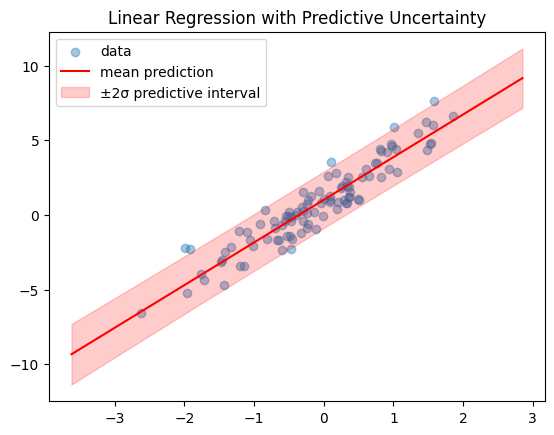

In [34]:
xs = np.linspace(X.min() - 1, X.max() + 1, 200)
means = []
stds = []

for x in xs:
    m, s = predictive_interval(x, theta_ne, X, sigma2_hat)
    means.append(m)
    stds.append(s)

means = np.array(means)
stds = np.array(stds)

plt.scatter(X, y, alpha=0.4, label="data")
plt.plot(xs, means, color="red", label="mean prediction")
plt.fill_between(
    xs,
    means - 2 * stds,
    means + 2 * stds,
    color="red",
    alpha=0.2,
    label="±2σ predictive interval"
)
plt.legend()
plt.title("Linear Regression with Predictive Uncertainty")
plt.show()


## KEY TAKEAWAY
Increasing observation noise results in wider confidence intervals and flatter likelihood surfaces, reflecting higher uncertainty while preserving the equivalence between least squares estimation and maximum likelihood estimation.
